Mean Squared Error: 0.1897


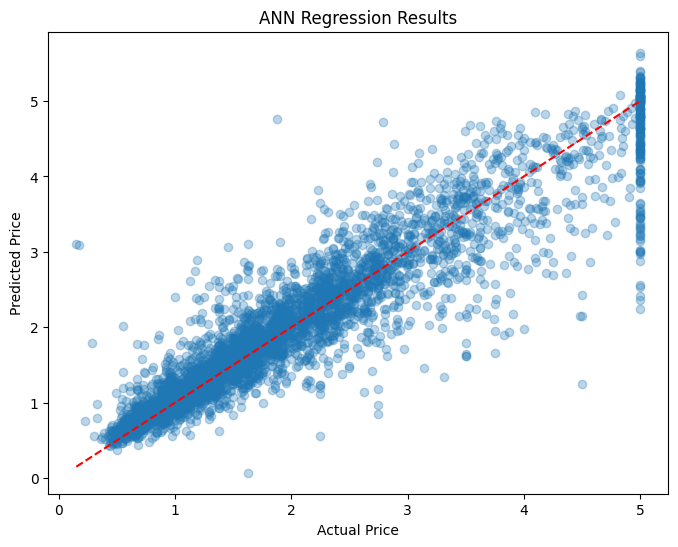

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors

# 1. 加载数据 [cite: 135]
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target  # 目标：房屋中位数价格 [cite: 115]

# 2. 构造邻域特征 (Graph-based Features) [cite: 116, 117, 126]
# 重要：为避免数据泄露，先拆分训练集和测试集 [cite: 128, 129]
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

def add_graph_features(df, reference_df, reference_y, k=5):
    """
    使用地理坐标（纬度/经度）定义邻域关系 [cite: 114, 119]
    """
    coords = reference_df[['Latitude', 'Longitude']]
    target_coords = df[['Latitude', 'Longitude']]
    
    # 使用 K-近邻定义邻居 [cite: 119]
    nbrs = NearestNeighbors(n_neighbors=k).fit(coords)
    distances, indices = nbrs.kneighbors(target_coords)
    
    # 计算邻居的平均房价 [cite: 124, 127]
    neighbor_prices = []
    for idx_list in indices:
        neighbor_prices.append(np.mean(reference_y[idx_list]))
    
    new_df = df.copy()
    new_df['Avg_Neighbor_Price'] = neighbor_prices # 增加邻域统计特征 [cite: 125]
    return new_df

# 仅使用训练数据构建特征 [cite: 128]
X_train_enhanced = add_graph_features(X_train_raw, X_train_raw, y_train)
X_test_enhanced = add_graph_features(X_test_raw, X_train_raw, y_train)

# 3. 数据预处理（标准化） [cite: 136, 171]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_enhanced)
X_test_scaled = scaler.transform(X_test_enhanced)

# 4. 构建与训练 ANN 模型 [cite: 131, 148, 172]
# 使用 MLPRegressor（对应 Lab 8/9 的前馈神经网络结构）
model = MLPRegressor(
    hidden_layer_sizes=(64, 32), # 隐藏层
    activation='relu',           # 非线性激活函数 [cite: 132, 173]
    solver='adam',               # 优化器（基于梯度的更新）
    alpha=1e-4,                  # 正则化（Lab 8 知识点）
    max_iter=500,
    random_state=42
)

model.fit(X_train_scaled, y_train)

# 5. 性能评估 [cite: 140, 154]
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred) # 使用 MSE 损失函数 [cite: 131, 173]

print(f"Mean Squared Error: {mse:.4f}")

# 可视化结果 [cite: 181]
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("ANN Regression Results")
plt.show()